In [1]:
import skysurvey
import numpy as np
import sncosmo
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import corner
import pandas
from code import *

In [2]:
import warnings
from iminuit.warnings import IMinuitWarning
warnings.filterwarnings('ignore', category=IMinuitWarning) 

# skysurvey tests

In [12]:
snia = skysurvey.SNeIa()

In [13]:
data = snia.draw(size=10_000, inplace=True)

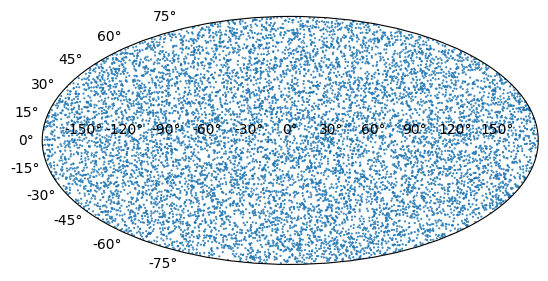

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

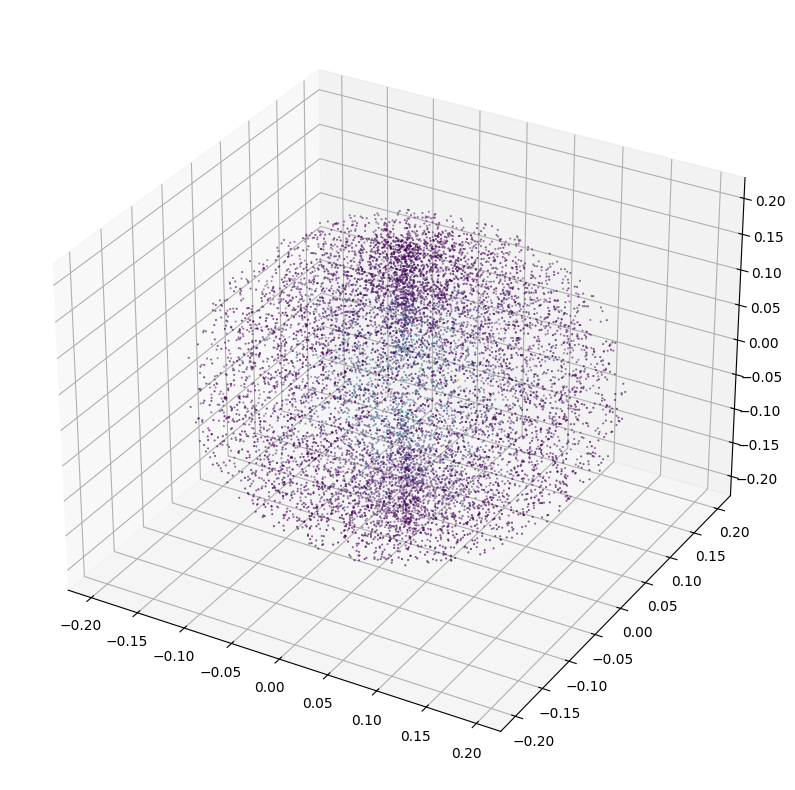

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

count, bin = np.histogramdd([snia.data["ra"], snia.data["dec"], snia.data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [snia.data["ra"] - binra.min(), snia.data["dec"] - bindec.min(), snia.data["z"] - binz.min()]
).T


def density_tree(
    pts: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    dist_id, nn_id = tree.query(pts, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_tree(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.sin(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.cos(snia.data["dec"]) * snia.data["z"],
    s=1,
    c=c,
    marker=".",
)

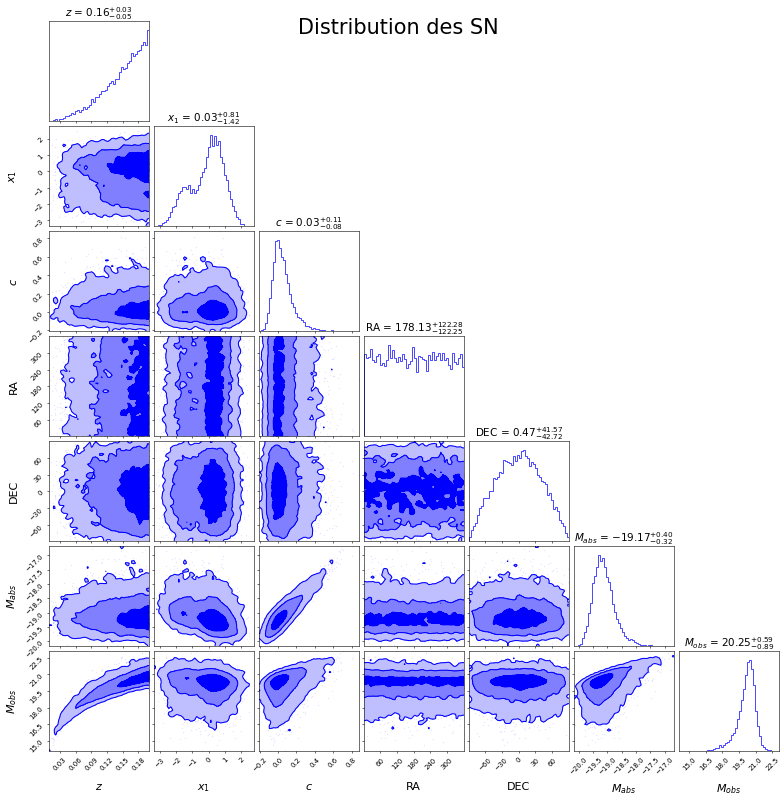

In [17]:
fig = corner_(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$M_{abs}$", r"$M_{obs}$"],
    title='Distribution des SN',
)

In [18]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [25]:
import pickle

with open('../data/ztf_survey.pkl','rb') as file:
    survey = pickle.load(file)

In [40]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:151: UserWarning: you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas
  warnings.warn("you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas")
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [128]:
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

In [130]:
len(detected)

360

Text(0.5, 0.98, 'Distribution des SN détectées')

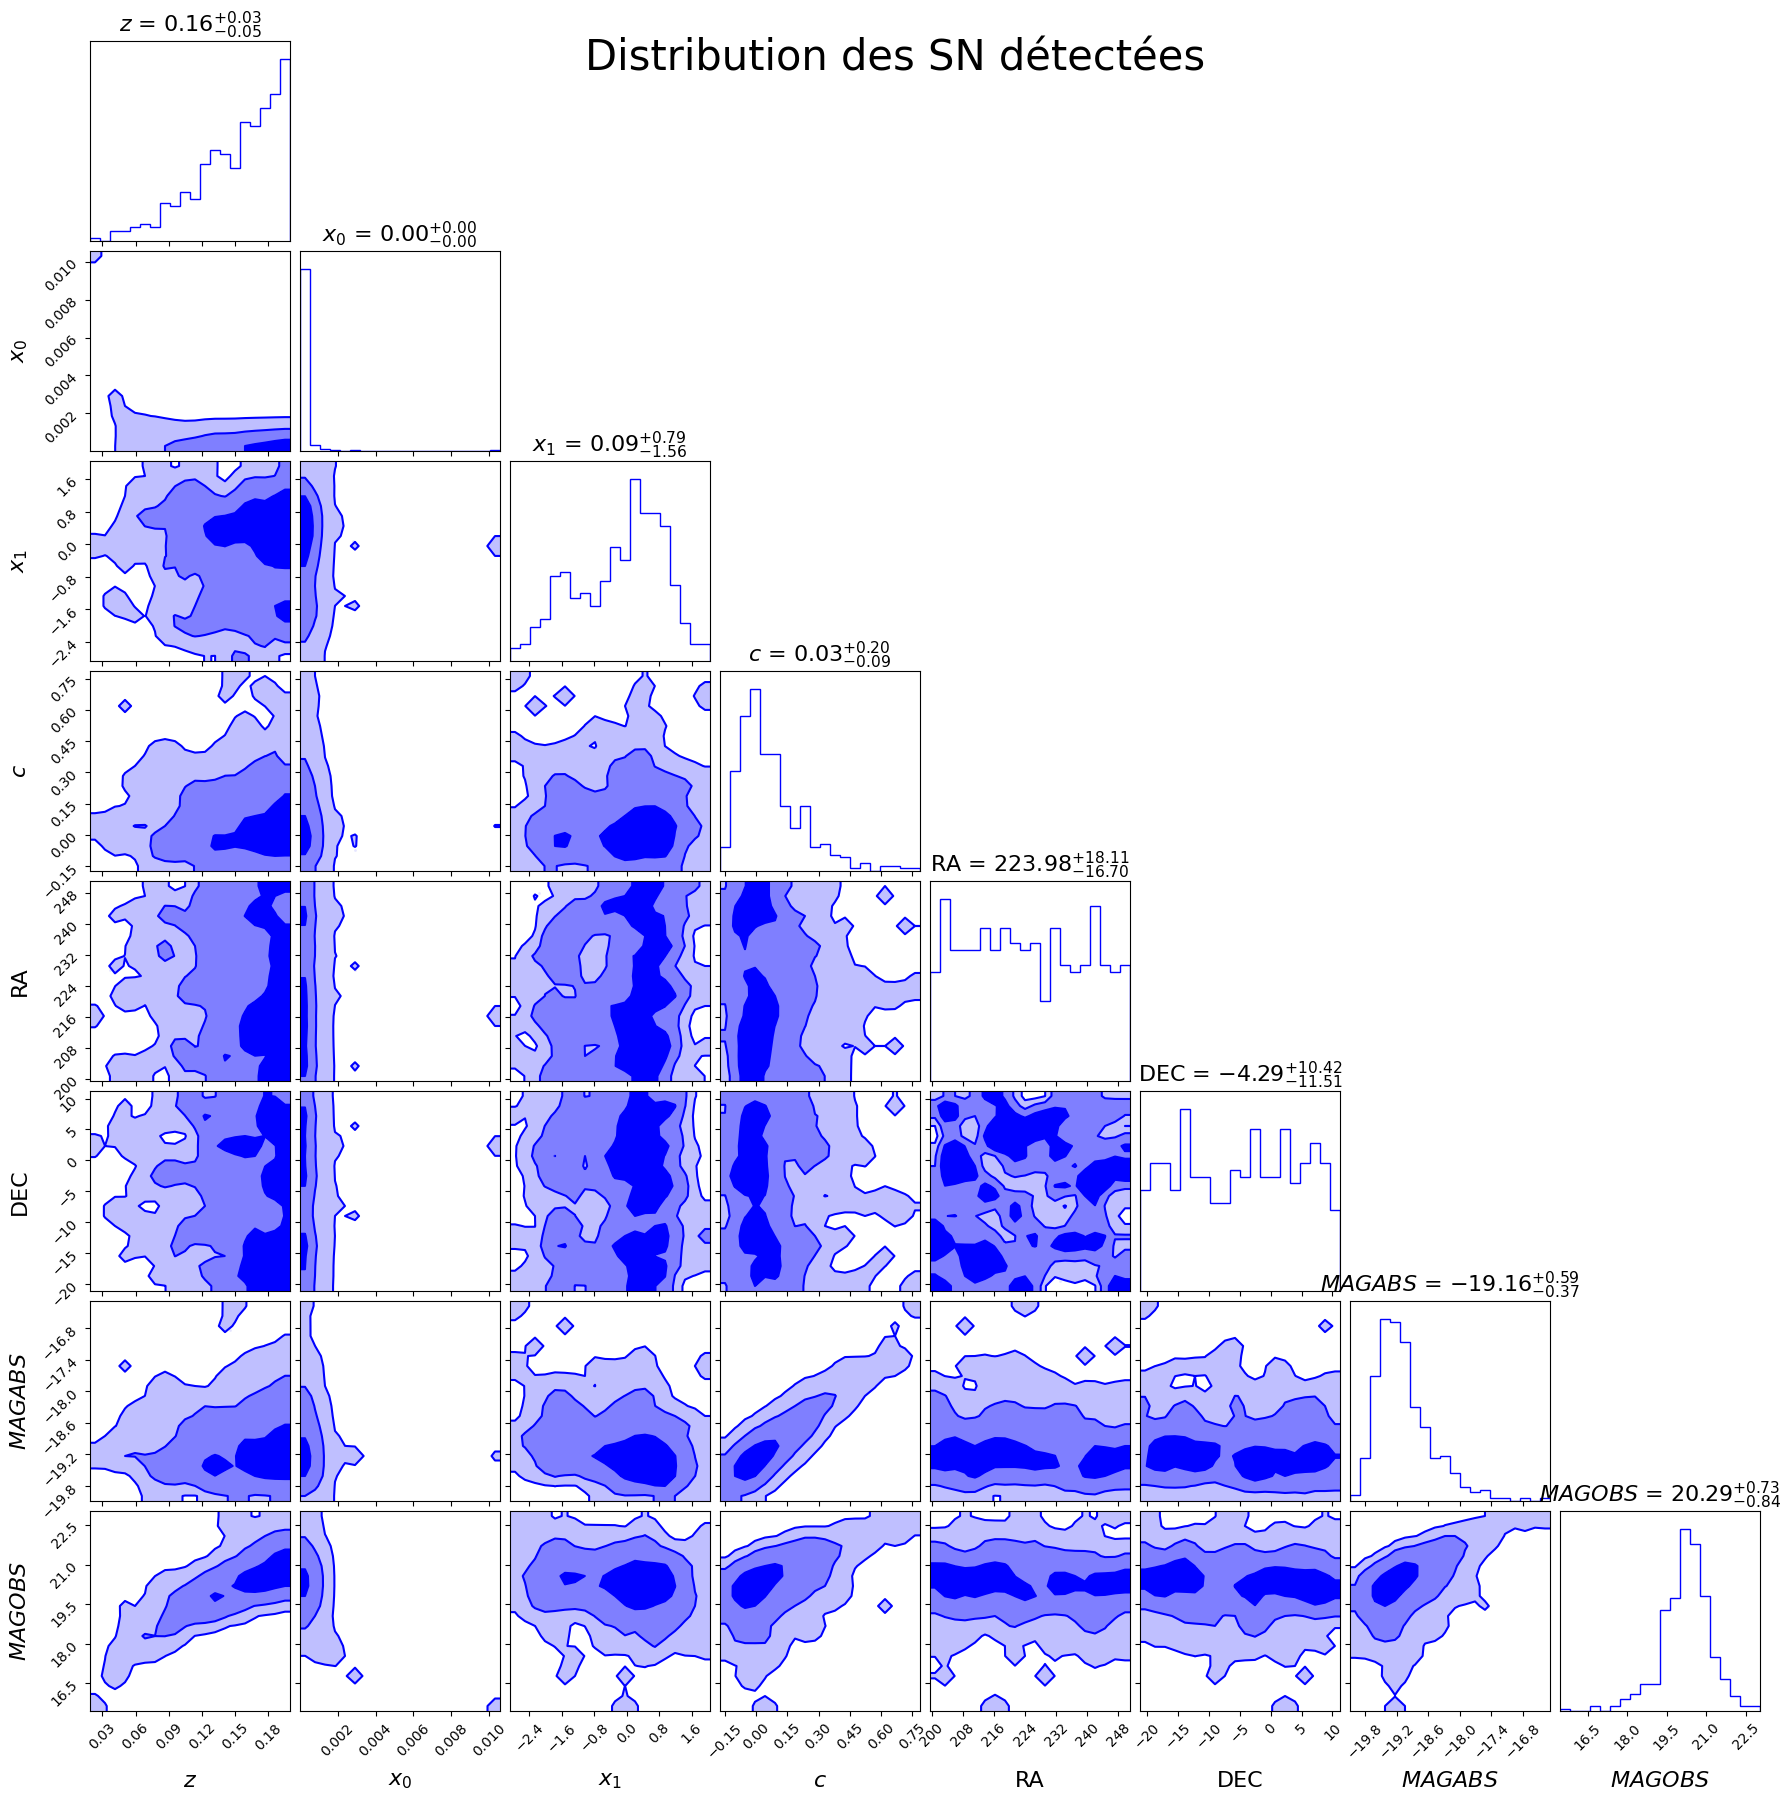

In [81]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

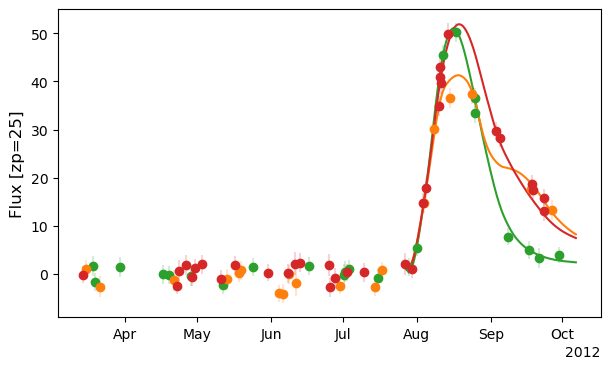

In [18]:
_ = dset.show_target_lightcurve(index=detected[212])

In [85]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [87]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
61    z       0.165950       NaN           NaN           NaN           NaN   
      t0  56076.642355  0.000119  1.406037e-08 -8.320405e-15  3.406144e-10   
      x0      0.000141  0.000003 -8.320405e-15  8.518550e-12 -1.609167e-07   
      x1     -1.494876  0.173515  3.406144e-10 -1.609167e-07  3.012934e-02   
      c      -0.100651  0.016845  5.986491e-11 -4.064239e-08  7.499385e-04   
...                ...       ...           ...           ...           ...   
9976  z       0.175650       NaN           NaN           NaN           NaN   
      t0  56040.948513  0.020004  4.001741e-04  2.702059e-13 -1.271361e-08   
      x0      0.000044  0.000002  2.702059e-13  3.919417e-12 -2.269164e-07   
      x1     -0.518954  0.285869 -1.271361e-08 -2.269164e-07  8.186272e-02   
      c       0.366539  0.031626 -4.540617e-09 -5.675693e-08  2.304500e-03   

                 cov_c         truth  
index                                 
61    z            NaN       0.16595  
      t0  5.986491e-11  56075.347656  
      x0 -4.064239e-08       0.00014  
      x1  7.499385e-04         -1.77  
      c   2.838648e-04     -0.111124  
...                ...           ...  
9976  z            NaN       0.17565  
      t0 -4.540617e-09  56040.851562  
      x0 -5.675693e-08      0.000045  
      x1  2.304500e-03        -0.195  
      c   1.001014e-03      0.343443  

[1800 rows x 7 columns]

In [88]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

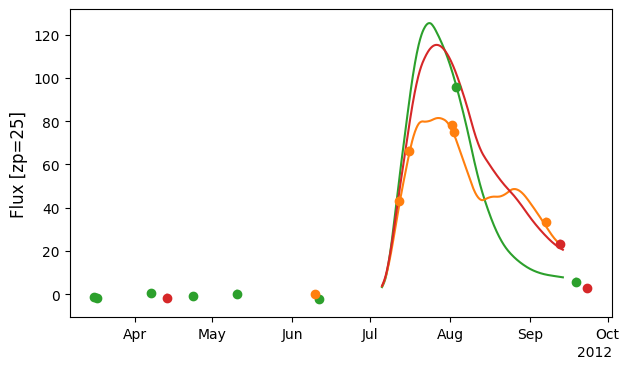

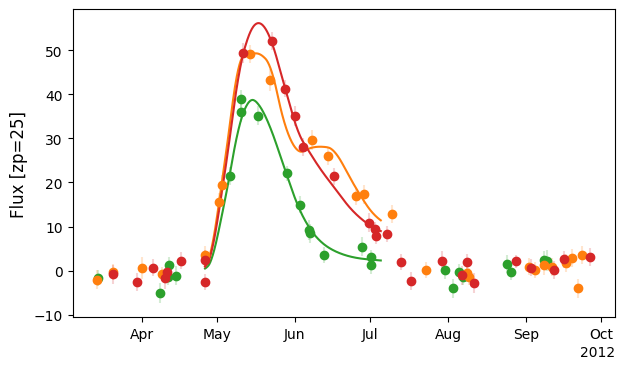

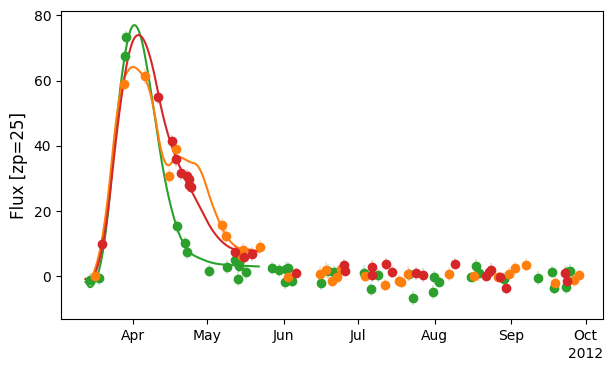

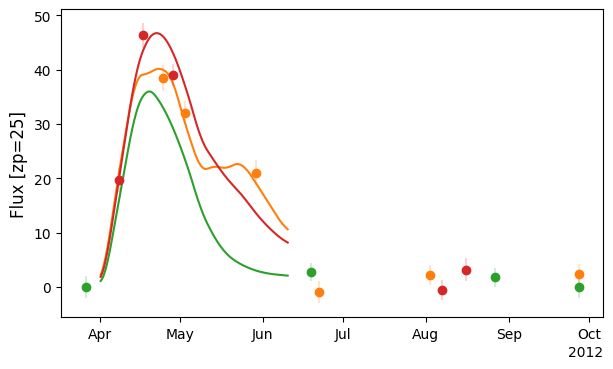

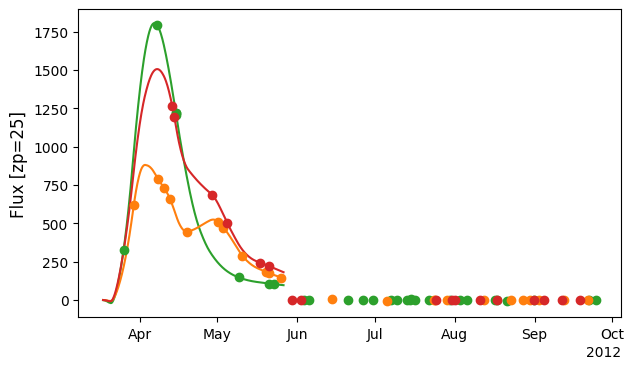

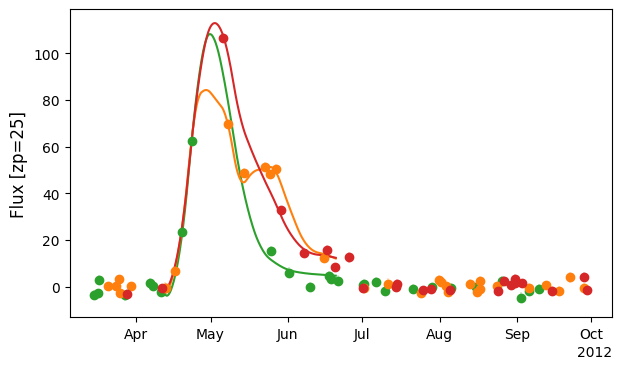

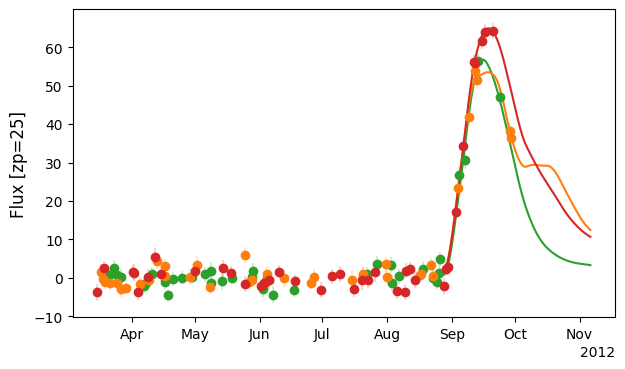

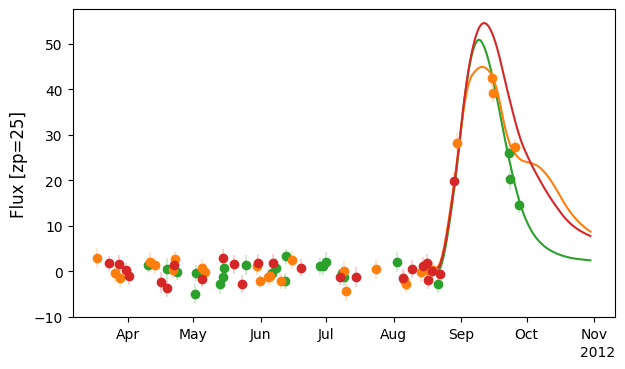

In [89]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

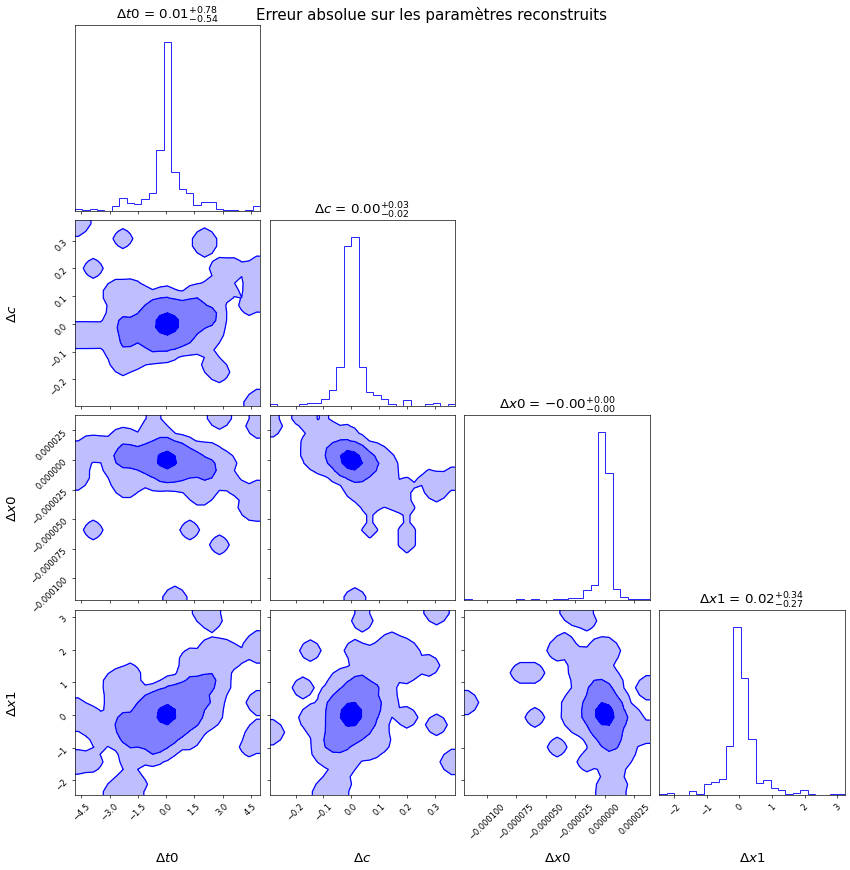

In [158]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)

# Uchuu tests

In [3]:
import time
start = time.time()
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS','R_MAG_ABS','R_MAG_APP'])
print(time.time() - start,'s')

Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')
3.192869186401367 s


In [ ]:
# bgs_df[bgs_df['z'] < 0.15].to_csv('./data/Uchuu.csv')

In [4]:
%matplotlib inline

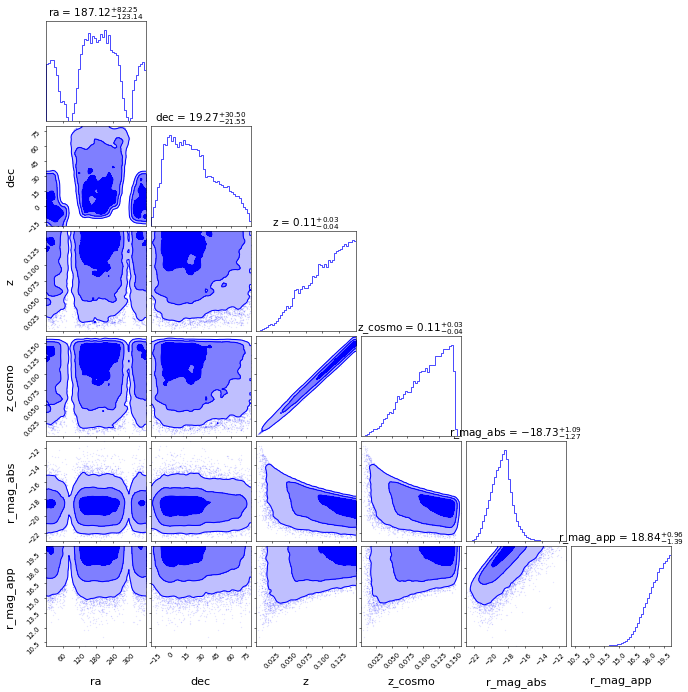

In [5]:
fig = corner_(bgs_df[::50], var_names=['ra','dec','z','z_cosmo','r_mag_abs','r_mag_app'])

In [6]:
survey = extract_ztf()
survey.date_range

(58288.17, 59211.227)

In [7]:
snia = SNeIa()
data = snia.draw(size=10000, inplace=True,  zmax=0.15)
# data = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.15, inplace=True)

<Axes: ylabel='Frequency'>

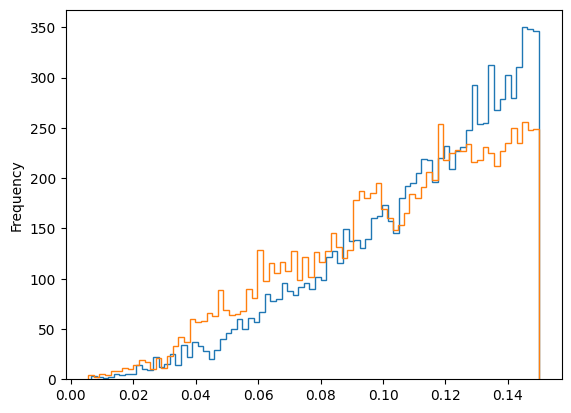

In [8]:
%matplotlib inline
snia.data['redshift'].plot.hist(bins=80, histtype='step')
snia.data['z'].plot.hist(bins=80, histtype='step')

In [9]:
start = time.time()
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()
time.strftime('%H:%M:%S', time.gmtime(stop - start))

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
100%|██████████| 15047/15047 [01:11<00:00, 211.28it/s]
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


829.5366625785828 s


In [155]:
dataset = dset.get_ndetection(detlimit=7) > 10
detected = dataset[dataset].index
len(detected)

4588

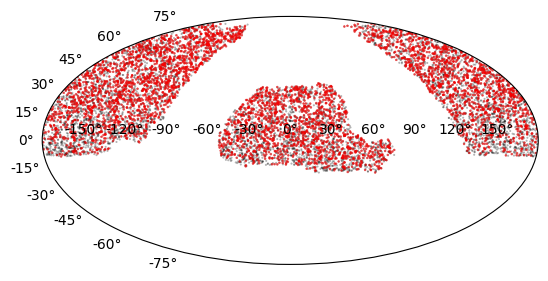

In [184]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
mollweide_scatter(dset.targets.data, ax=ax,)
mollweide_scatter(dset.targets.data.loc[detected], ax=ax, color='r', marker='*', alpha=0.5)
plt.savefig('../figures/Uchuu_scatter.png')


In [342]:
from tqdm.notebook import tqdm
n_det = []
dset.data["detected"] = (dset.data["flux"]/dset.data["fluxerr"]) > 5
for i in tqdm(detected):
    target = dset.targets.data.loc[i]
    obs_data = dset.data[dset.data["detected"]].loc[i]
    n_det.append((np.sum(obs_data["time"].between(target["t0"] - 50, target["t0"])), np.sum(obs_data["time"].between(target["t0"], target["t0"]+200))))

  0%|          | 0/4588 [00:00<?, ?it/s]

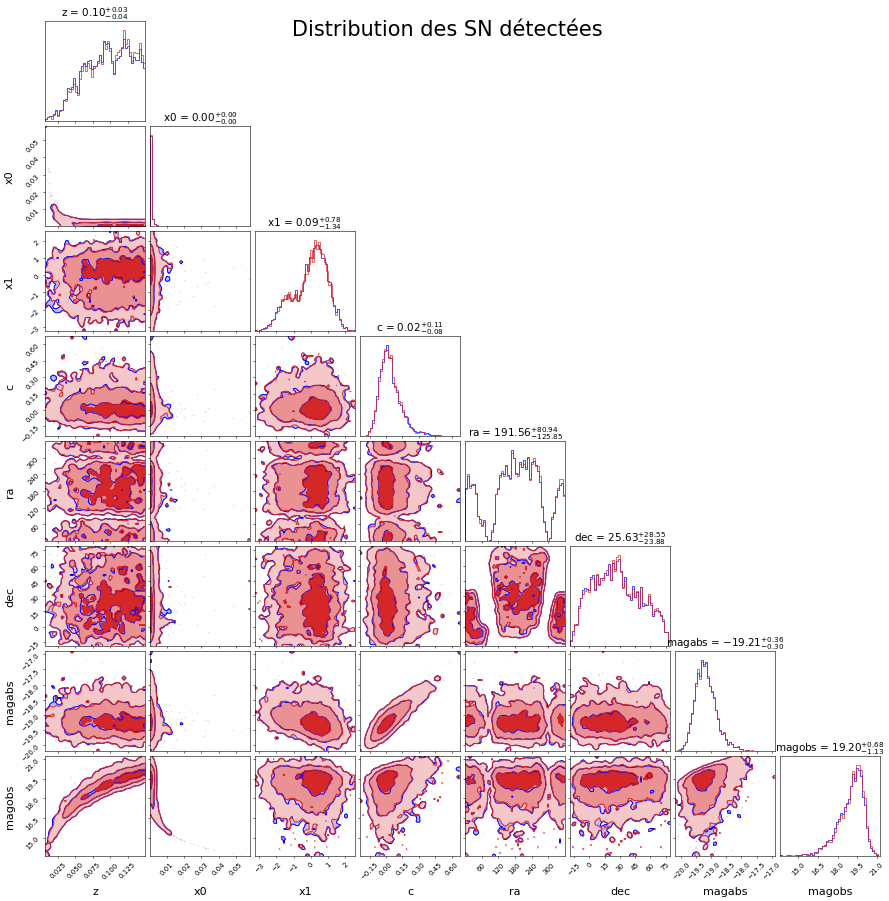

In [408]:
%matplotlib inline
fig = corner_(dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ], title='Distribution des SN détectées')
_=corner_(dset.targets.data.loc[detected[~np.any(np.array(n_det) < 3, axis=1)]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig = fig,
    color='tab:red')


In [390]:
len(detected[~np.any(np.array(n_det, dtype=tuple) < 3, axis=1)])/len(detected)

0.8506974716652136

In [350]:
id_det=detected[~np.any(np.array(n_det) < 3, axis=1)][:400]

ATTENTION 

In [352]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected[:400],
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

100%|██████████| 400/400 [03:18<00:00,  2.02it/s]


In [ ]:
nopes = np.where(np.any(np.array(n_det, dtype=tuple) == 0, axis=1))[0]

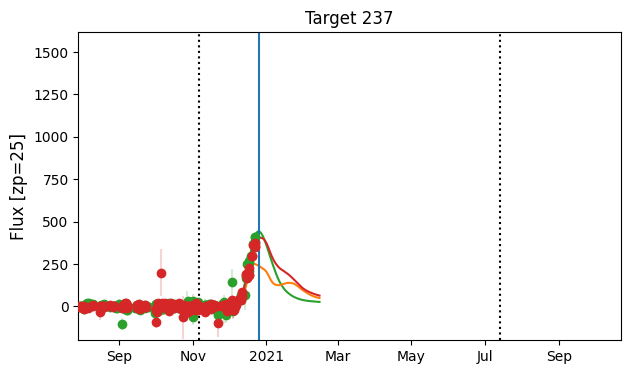

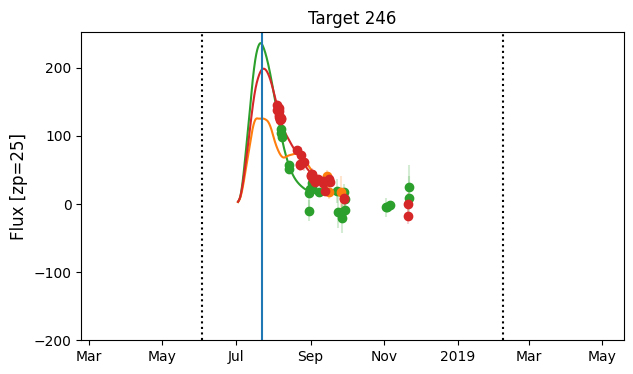

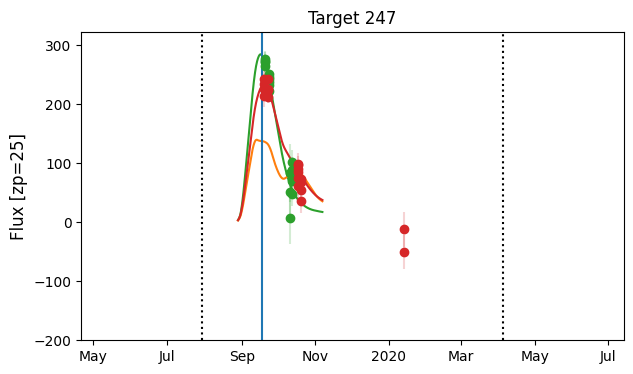

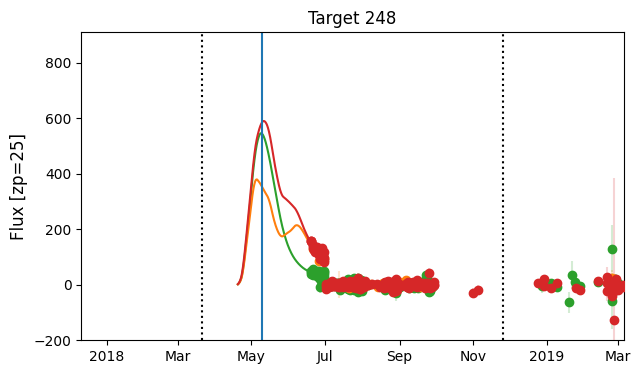

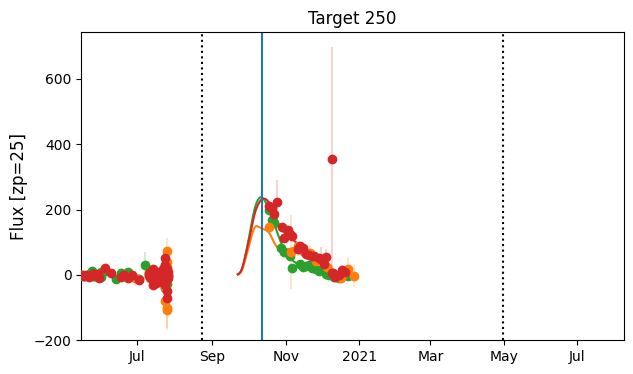

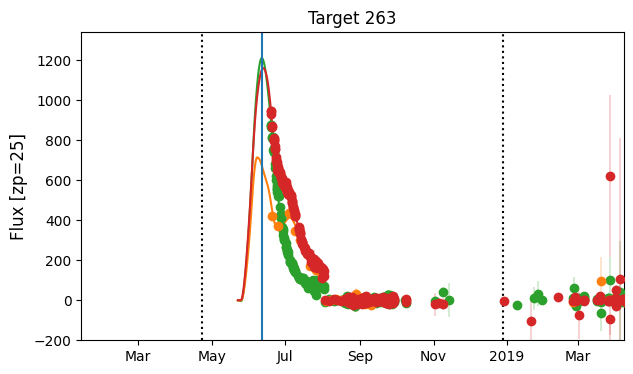

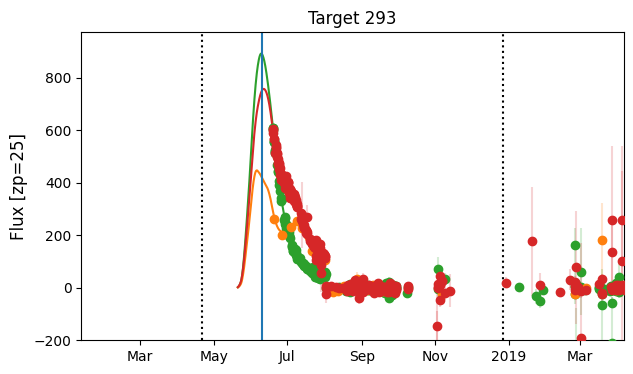

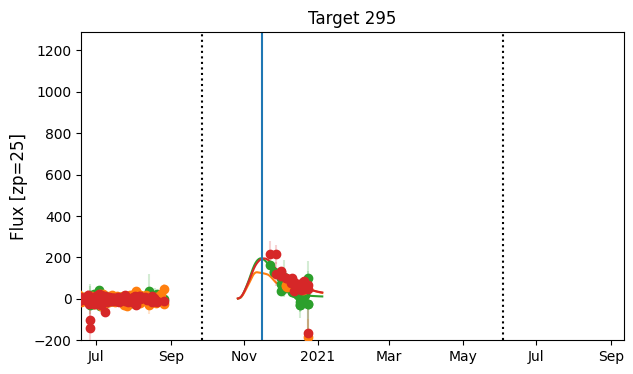

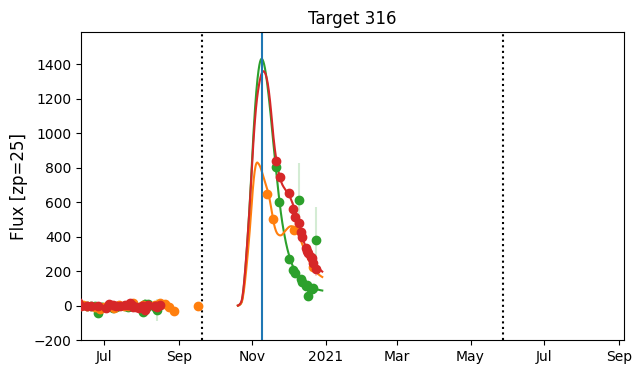

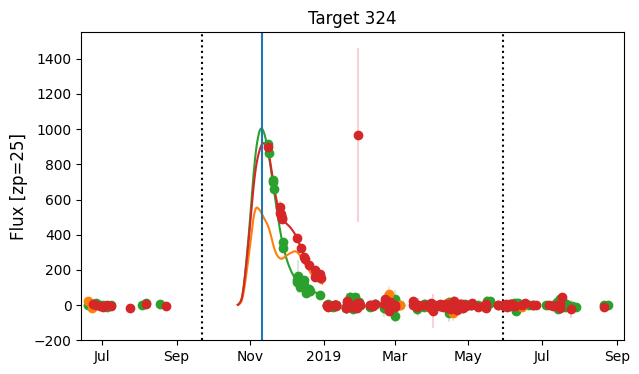

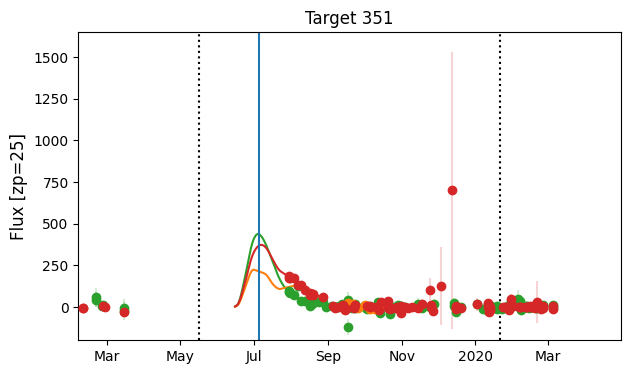

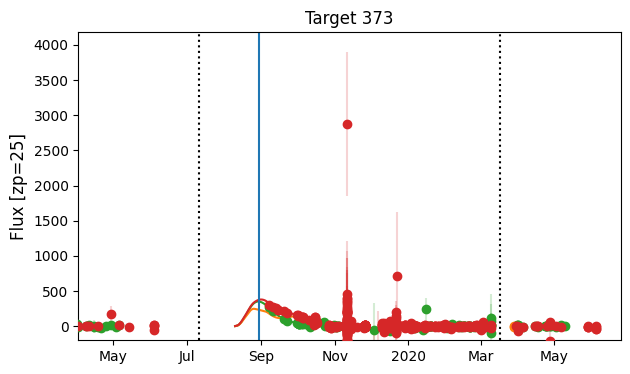

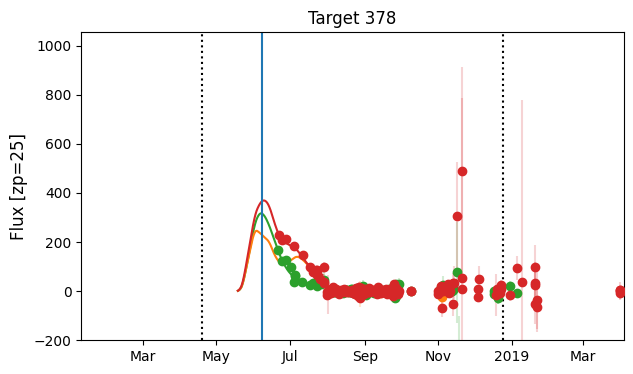

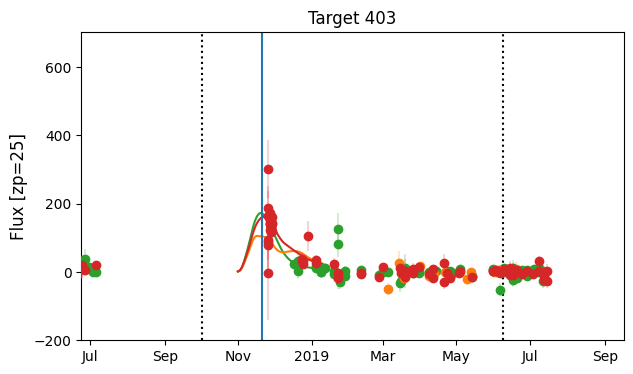

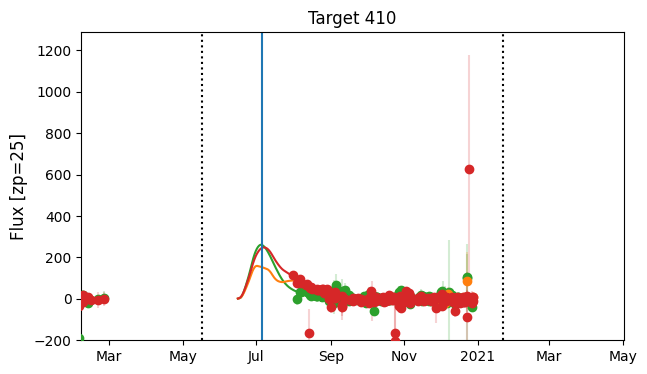

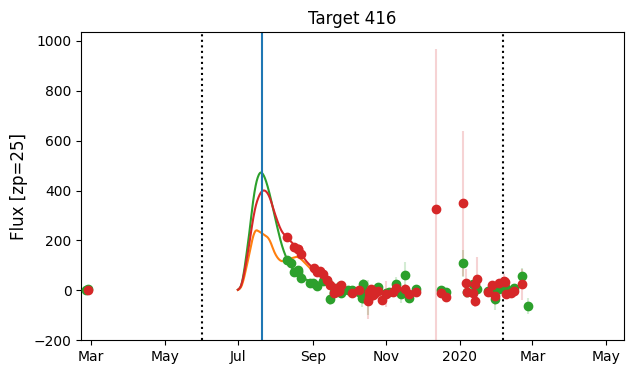

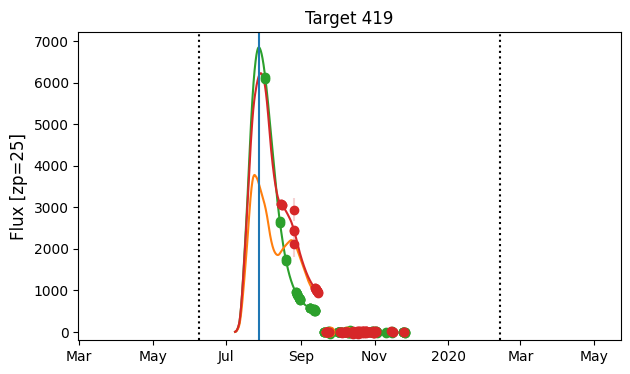

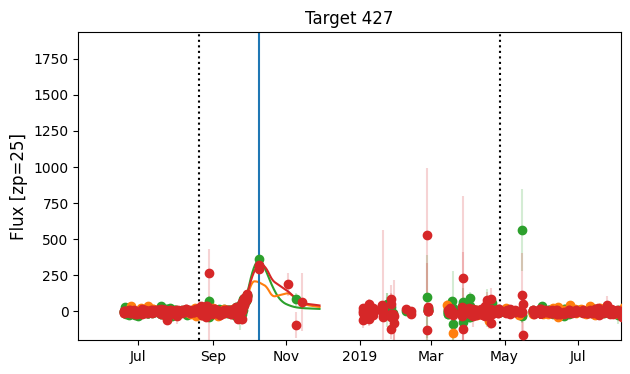

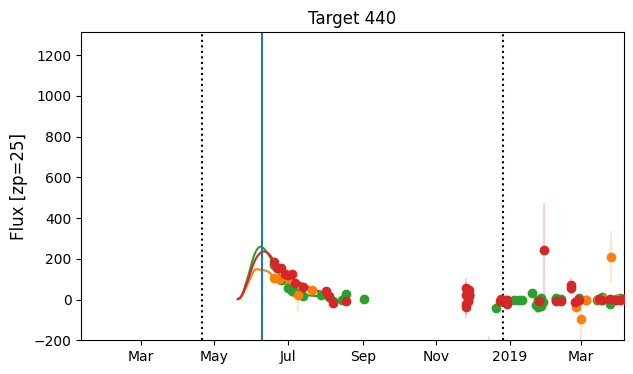

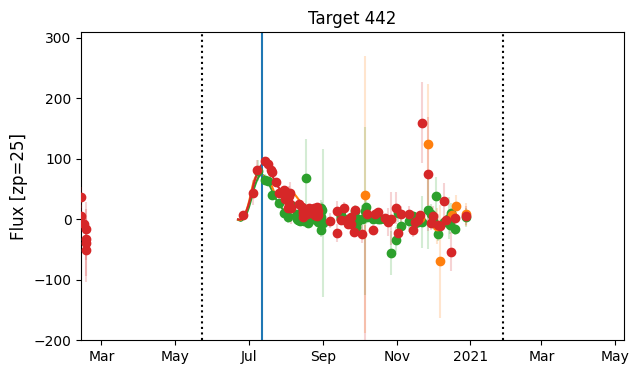

In [338]:
from astropy.time import Time

for i in nopes[20:40]:
    _ = dset.show_target_lightcurve(index=detected[i])
    plt.ylim(-200)
    target = dset.targets.data.loc[detected[i]]
    plt.axvline(Time(target["t0"], format="mjd").datetime)

    plt.axvline(Time(target["t0"]-50, format="mjd").datetime, linestyle='dotted', c='k')
    plt.axvline(Time(target["t0"]+200, format="mjd").datetime, linestyle='dotted', c='k')
    
    plt.xlim(Time(target["t0"]-150, format="mjd").datetime, Time(target["t0"] +300, format="mjd").datetime)
    plt.title(f"Target {i}")


In [356]:

better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected[:400])] - \
                      results["truth"].loc[map(lambda x: (x, col), detected[:400])])
        for col in guess.keys()
    }
)
better_results

,t0,c,x0,x1
0,0.513224,0.015435,-0.000007,0.482848
1,0.169728,0.00755,-0.000001,0.104224
2,-0.167093,0.005455,0.000005,0.094041
3,4.999927,-0.097704,-0.003992,0.80242
4,0.027446,-0.001483,-0.000005,0.145518
...,...,...,...,...
395,-0.087093,-0.002795,0.000002,-0.006235
396,1.544246,-0.051739,0.000008,1.828249
397,0.702503,0.761474,-0.000214,1.08198
398,0.000854,0.002598,-0.000056,-0.009745


In [477]:
np.sum(~np.any(np.array(n_det[:400]) < 3, axis=1))

344

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

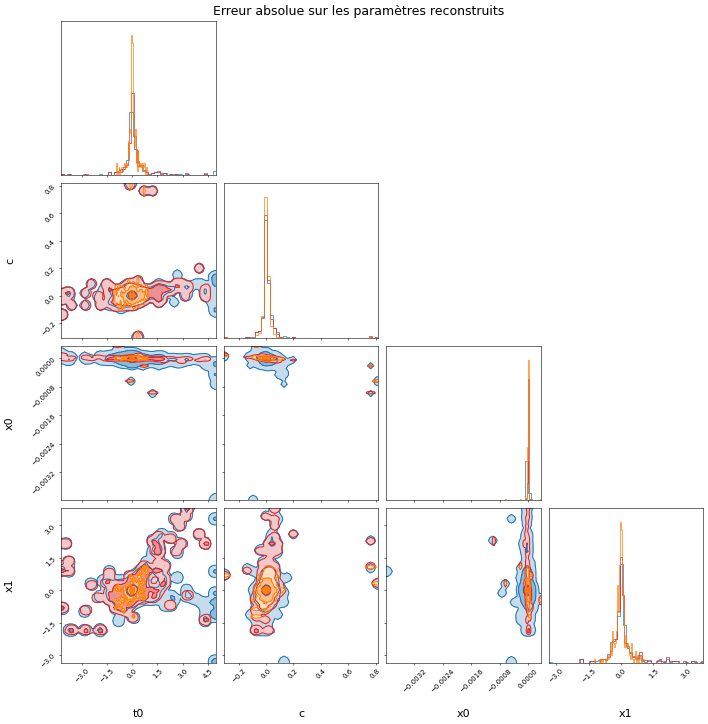

In [434]:
fig = plt.figure(figsize=(15,15),dpi=60)
corner_(better_results,
    fig=fig,
    var_names=list(guess.keys()),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    color='tab:blue',
    show_titles=False)
corner_(better_results[~np.any(np.array(n_det[:400]) < 5, axis=1)],
    fig=fig,
    var_names=list(guess.keys()),
    color='tab:red',
    show_titles=False)
corner_(better_results[~np.any(np.array(n_det[:400]) < 5, axis=1) & better_results["t0"].between(-1,1)],
    fig = fig,
    var_names=list(guess.keys()),
    color='tab:orange',
    show_titles=False)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)
# plt.savefig('../figures/Uchuu_reconstructed_cuts')

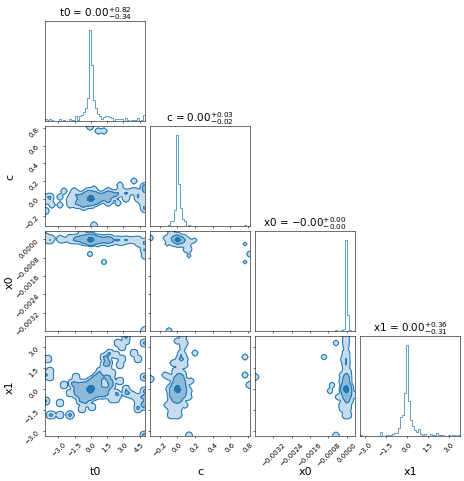

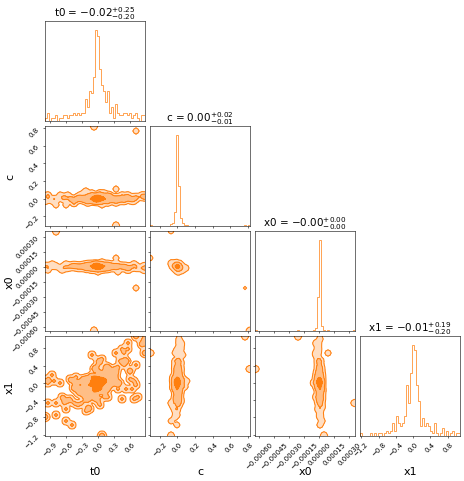

In [444]:
fig=corner_(better_results,
    var_names=list(guess.keys()),
    color='tab:blue')

fig=corner_(better_results[~np.any(np.array(n_det[:400]) < 5, axis=1) & better_results["t0"].between(-1,1)],
    var_names=list(guess.keys()),
    color='tab:orange')
# plt.savefig('../figures/Uchuu_cut')

In [455]:
from corner import quantile

np.diff(quantile(better_results["x1"], q=[0.16,0.84]))/np.diff(quantile(kept["x1"], q=[0.16,0.84]))

array([1.6919411390011552], dtype=object)

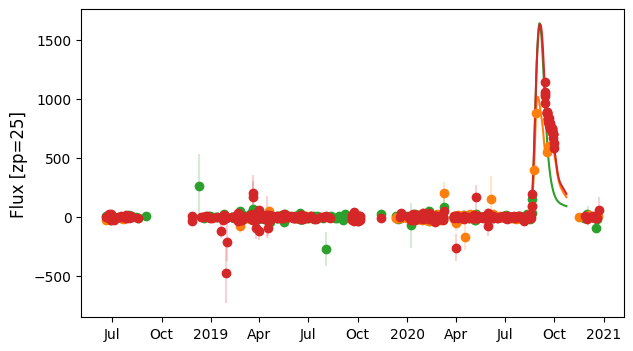

In [439]:
kept = better_results[~np.any(np.array(n_det[:400]) < 5, axis=1) & better_results["t0"].between(-1,1)].copy()

_ = dset.show_target_lightcurve(index=detected[kept[kept["x0"]==kept['x0'].max()].index[0]])


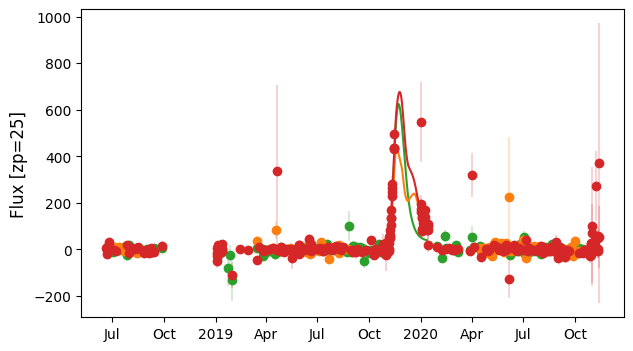

In [440]:
_ = dset.show_target_lightcurve(index=detected[kept[kept["x0"]==kept['x0'].min()].index[0]])


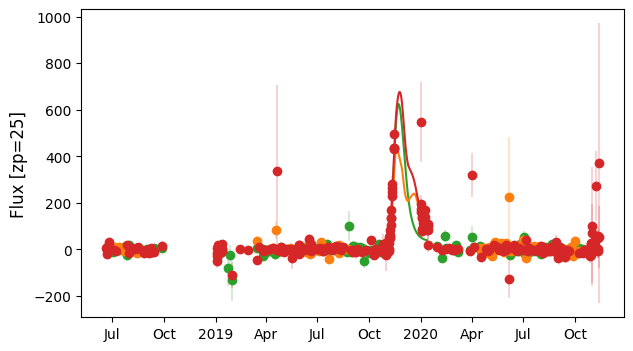

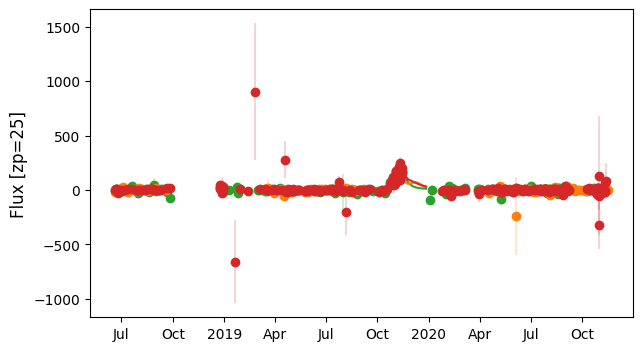

In [441]:
_ = dset.show_target_lightcurve(index=detected[kept[kept["c"]==kept['c'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[kept[kept["c"]==kept['c'].min()].index[0]])